# Kachowka Dam Break - Rapid Impact Assessment Using Open-source Earth Observation

On June 6, 2023, the Kakhovka Dam in Ukraine broke. We do not yet know who or what was responsible for the collapse of the dam. What we do know, however, are the devastating consequences for the region downstream of the Dnipro River - especially for the local population.

Using freely-available optical remote sensing data from [ESA](https://www.esa.int/) and the open-source software [EOdal](https://github.com/EOA-team/eodal), timely monitoring of the flood disaster is possible and allows a precise assessment of the consequences for the local population and agriculture.

This notebook enables users to follow the development at the Kachowka Dam as well as downstream at the [Dnipro]() - for example in the city of Kherson - by means of satellite images.

First, we need to install EOdal from [pypi](https://pypi.org/project/eodal/).

!pip install eodal

## Program logic

We use [EOdal](https://github.com/EOA-team/eodal) to query the [STAC](https://stacspec.org/en/) of, e.g., [Microsoft Planetary Computer](https://planetarycomputer.microsoft.com/) to fetch the latest [Sentinel-2](https://sentinel.esa.int/web/sentinel/missions/sentinel-2) scenes covering the [Kachowka dam](https://en.wikipedia.org/wiki/Kakhovka_Dam) and its downstream areas prone to flooding risk after the collapse of the dam on June 6th, 2023. This way, we get an impression about the situation *before* and *after* the deconstruction of the dam, enabling to study the impact of the resulting floodings on local livelihoods and agricultural productivity.

The code below uses the [EOdal](https://github.com/EOA-team/eodal) `Mapper` class to

1. query the available Sentinel-2 imagery between June 1st 2023 and today
2. fetch the Sentinel-2 data and load it for convenient handling into a EOdal `SceneCollection`
3. calculate the Normalized Difference Vegetetation Index ([NDVI](https://gisgeography.com/ndvi-normalized-difference-vegetation-index/)) and Normalized Difference Water Index ([NDWI](https://en.wikipedia.org/wiki/Normalized_difference_water_index)) to asses the extent of flooded areas and the impacts on vegetation and agriculture
4. display the results

In [9]:
# display EOdal version information
import eodal
print(eodal.__version__)

0.2.1


First, we two functions to be used for processing the Sentinel-2 data:

- `mask_clouds` masks out clouds and cloud shadows based on the [Scene Classification Layer](https://sentinel.esa.int/web/sentinel/user-guides/sentinel-2-msi/processing-levels/level-2) delivered with the atmospherically-corrected Sentinel-2 imagery
- `get_s2_data` executes the actual program logic to load the imagery into this notebook

In [10]:
import geopandas as gpd

from datetime import datetime
from eodal.config import get_settings
from eodal.core.scene import SceneCollection
from eodal.core.sensors.sentinel2 import Sentinel2
from eodal.mapper.feature import Feature
from eodal.mapper.filter import Filter
from eodal.mapper.mapper import Mapper, MapperConfigs

from pathlib import Path
from typing import List


Settings = get_settings()
# set to True to connect to MS Planetary Computer
Settings.USE_STAC = True


def mask_clouds(ds: Sentinel2) -> Sentinel2:
    """
    Mask clouds and shadows in Sentinel-2 data
    before calculating the NDVI

    :param ds:
        Sentinel-2 dataset
    :return:
        Sentinel-2 dataset with masked clouds and shadows
    """
    # bring scene classification layer to 10 m resolution
    ds.resample(inplace=True, target_resolution=10)
    return ds  #.mask_clouds_and_shadows(cloud_classes=[1, 2, 3, 8, 9, 10, 11])


def get_s2_data(
    mapper: Mapper
) -> SceneCollection:
    """
    Fetch Sentinel-2 scenes

    :param mapper:
        eodal Mapper instance
    """
    mapper.query_scenes()

    # Comment:
    # before reading the scenes, you can check the metadata
    # by calling mapper.metadata to do further filtering

    # load the scenes available from STAC
    # using Sentinel-2 bands B02 (blue), B03 (green), B04 (red) and B08 (nir)
    scene_kwargs = {
        'scene_constructor': Sentinel2.from_safe,
        'scene_constructor_kwargs': {
            'band_selection': ["B02", "B03", "B04", "B08"]},
        'scene_modifier': mask_clouds
        }
    mapper.load_scenes(scene_kwargs=scene_kwargs)
    return mapper.data


## User Inputs

The user inputs below tell [EOdal](https://github.com/EOA-team/eodal) how to query the STAC archive by
- geographic location
- time period
- EO platform and sensor (a.k.a., "collection")
to fetch the latest Sentinel-2 imagery over the Kachowka dam region.

**The inputs below can be used in their current form** or modified according to users' needs, e.g., by modifying the geographic and/or temporal extent.

In [12]:
from shapely.geometry import box

# -------------------------- Paths -------------------------------------
# define the output directory where to save the NDVI GeoTiff files
output_dir = Path('./data')
output_dir.mkdir(exist_ok=True)

# user-inputs
# -------------------------- Collection -------------------------------
collection: str = 'sentinel2-msi'

# ------------------------- Time Range ---------------------------------
time_start: datetime = datetime(2023, 6, 1)  		# year, month, day (incl.)
time_end: datetime = datetime.now()   		# year, month, day (incl.)

# ----------------------- Cloudy Pixel Percentage ----------------------
cloudy_pixel_percentage: int = 90  # percent (scene-wide)

# ---------------------- Spatial Feature  -----------------------------

geom = Path('kachowka_refined.gpkg')
feature = Feature.from_geoseries(gpd.read_file(geom).geometry)

# ------------------------- Metadata Filters ---------------------------
metadata_filters: List[Filter] = [
    Filter('cloudy_pixel_percentage', '<=', cloudy_pixel_percentage),
    Filter('processing_level', '==', 'Level-2A')]

# setup the EOdal Mapper configurations
mapper_configs = MapperConfigs(
    collection=collection,
    time_start=time_start,
    time_end=time_end,
    feature=feature,
    metadata_filters=metadata_filters)

# now, a new Mapper instance is created
mapper = Mapper(mapper_configs)

### Fetching the metadata

First, we list the scenes available, i.e., the scenes found by querying the [STAC endpoint of Microsoft Planetary Computer](https://planetarycomputer.microsoft.com/api/stac/v1/collections/sentinel-2-l2a) which is supported natively within EOdal.

The metadata is returned as a [geopandas.GeoDataFrame](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.html) and is displayed below. Since the area queried is fairly large (100 by 80 km2, approximately), we have to read data from four [Sentinel-2 tiles](https://eatlas.org.au/data/uuid/f7468d15-12be-4e3f-a246-b2882a324f59). This task is handled *automatically* by EOdal.

In [13]:
mapper.query_scenes()
mapper.metadata

,product_uri,scene_id,spacecraft_name,tile_id,sensing_date,cloudy_pixel_percentage,epsg,sensing_time,sun_azimuth_angle,sun_zenith_angle,geom,assets
7,S2B_MSIL2A_20230603T084559_R107_T36TWT_2023060...,S2B_OPER_MSI_L2A_TL_MSFT_20230603T131641_A0325...,Sentinel-2B,36TWT,2023-06-03,2.774573,32636,2023-06-03 08:45:59.024,155.736572,26.714233,"POLYGON ((34.44203 46.92524, 34.42030 46.87563...",{'AOT': {'href': 'https://sentinel2l2a01.blob....
8,S2B_MSIL2A_20230603T084559_R107_T36TWS_2023060...,S2B_OPER_MSI_L2A_TL_MSFT_20230603T131633_A0325...,Sentinel-2B,36TWS,2023-06-03,3.620626,32636,2023-06-03 08:45:59.024,155.074735,25.882101,"POLYGON ((34.44200 46.92516, 34.42030 46.87563...",{'AOT': {'href': 'https://sentinel2l2a01.blob....
9,S2B_MSIL2A_20230603T084559_R107_T36TVT_2023060...,S2B_OPER_MSI_L2A_TL_MSFT_20230603T152835_A0325...,Sentinel-2B,36TVT,2023-06-03,52.769053,32636,2023-06-03 08:45:59.024,153.194665,27.097576,"POLYGON ((31.66287 47.84591, 33.13047 47.85363...",{'AOT': {'href': 'https://sentinel2l2a01.blob....
10,S2B_MSIL2A_20230603T084559_R107_T36TVS_2023060...,S2B_OPER_MSI_L2A_TL_MSFT_20230603T131644_A0325...,Sentinel-2B,36TVS,2023-06-03,8.128048,32636,2023-06-03 08:45:59.024,152.514307,26.274703,"POLYGON ((31.68544 46.94616, 33.12827 46.95364...",{'AOT': {'href': 'https://sentinel2l2a01.blob....
3,S2A_MSIL2A_20230605T083601_R064_T36TWT_2023060...,S2A_OPER_MSI_L2A_TL_MSFT_20230605T142539_A0415...,Sentinel-2A,36TWT,2023-06-05,0.164285,32636,2023-06-05 08:36:01.024,150.612922,27.282335,"POLYGON ((32.99974 47.09385, 33.04734 47.22571...",{'AOT': {'href': 'https://sentinel2l2a01.blob....
4,S2A_MSIL2A_20230605T083601_R064_T36TWS_2023060...,S2A_OPER_MSI_L2A_TL_MSFT_20230605T172508_A0415...,Sentinel-2A,36TWS,2023-06-05,0.026483,32636,2023-06-05 08:36:01.024,149.824073,26.484560,"POLYGON ((32.99974 46.95371, 34.44251 46.94462...",{'AOT': {'href': 'https://sentinel2l2a01.blob....
5,S2A_MSIL2A_20230605T083601_R064_T36TVT_2023060...,S2A_OPER_MSI_L2A_TL_MSFT_20230605T142302_A0415...,Sentinel-2A,36TVT,2023-06-05,0.000000,32636,2023-06-05 08:36:01.024,148.178951,27.735574,"POLYGON ((32.91746 46.86454, 32.94180 46.93271...",{'AOT': {'href': 'https://sentinel2l2a01.blob....
6,S2A_MSIL2A_20230605T083601_R064_T36TVS_2023060...,S2A_OPER_MSI_L2A_TL_MSFT_20230605T142305_A0415...,Sentinel-2A,36TVS,2023-06-05,0.019367,32636,2023-06-05 08:36:01.024,147.382121,26.948230,"POLYGON ((32.59963 45.96280, 32.63143 46.05403...",{'AOT': {'href': 'https://sentinel2l2a01.blob....
0,S2A_MSIL2A_20230608T084601_R107_T36TWT_2023060...,S2A_OPER_MSI_L2A_TL_MSFT_20230608T153328_A0415...,Sentinel-2A,36TWT,2023-06-08,49.093780,32636,2023-06-08 08:46:01.024,154.929290,26.268070,"POLYGON ((34.44232 46.93558, 34.43290 46.91409...",{'AOT': {'href': 'https://sentinel2l2a01.blob....
1,S2A_MSIL2A_20230608T084601_R107_T36TVT_2023060...,S2A_OPER_MSI_L2A_TL_MSFT_20230608T153552_A0415...,Sentinel-2A,36TVT,2023-06-08,66.949093,32636,2023-06-08 08:46:01.024,152.367945,26.662801,"POLYGON ((31.66287 47.84591, 33.13047 47.85363...",{'AOT': {'href': 'https://sentinel2l2a01.blob....


### Loading the data

Once the *available data* has been queried we have to *load it* it into an EOdal `SceneCollection`. A `SceneCollection` is a collection of zero to *N* scenes with a scene being a Sentinel-2 image of a specific date and region of interest.

In [14]:
# fetch the data. This is the actual I/O operation.
mapper_pop = get_s2_data(mapper)

2023-06-09 20:34:59,210 eodal        INFO     Starting extraction of sentinel2 scenes
2023-06-09 20:40:03,939 eodal        INFO     Finished extraction of sentinel2 scenes


When the loading process is finished (it takes some minutes because of the large extent of the area and the need to [mosaic](https://en.wikipedia.org/wiki/Image_stitching) four Sentinel-2 into a single image) the data becomes available as an EOdal `SceneCollection`:

In [15]:
mapper.data

EOdal SceneCollection
----------------------
# Scenes:    3
Timestamps:    2023-06-03 08:45:59, 2023-06-05 08:36:01, 2023-06-08 08:46:01
Scene Identifiers:    S2B_MSIL2A_20230603T084559_N0509_R107_T36TWT_20230603T131640.SAFE&&S2B_MSIL2A_20230603T084559_N0509_R107_T36TWS_20230603T131632.SAFE&&S2B_MSIL2A_20230603T084559_N0509_R107_T36TVT_20230603T152834.SAFE&&S2B_MSIL2A_20230603T084559_N0509_R107_T36TVS_20230603T131643.SAFE, S2A_MSIL2A_20230605T083601_N0509_R064_T36TWT_20230605T142537.SAFE&&S2A_MSIL2A_20230605T083601_N0509_R064_T36TWS_20230605T172507.SAFE&&S2A_MSIL2A_20230605T083601_N0509_R064_T36TVT_20230605T142301.SAFE&&S2A_MSIL2A_20230605T083601_N0509_R064_T36TVS_20230605T142303.SAFE, S2A_MSIL2A_20230608T084601_N0509_R107_T36TWT_20230608T153327.SAFE&&S2A_MSIL2A_20230608T084601_N0509_R107_T36TVT_20230608T153551.SAFE&&S2A_MSIL2A_20230608T084601_N0509_R107_T36TVS_20230608T153329.SAFE

### Calculating spectral indices

As a third step, we now calculate two spectral indices: NDVI and NDWI.

- NDVI is sensitive to vegetation greeness, taking values between -1 and +1; the higher values >0 indicate bare soil and green vegetation, whereas values <0 are associated with, e.g., water bodies. **NDVI is widely used to detect green vegetation.**
- NDWI is sensitive to water bodies taking values between -1 and +1. Values >0 indicate the presence of open water surfaces in satellite imagery. **NDWI is used to detect water bodies**.

In [16]:
# calculate spectral indices including the NDVI and NDWI
for _, scene in mapper.data:
    scene.calc_si('NDVI', inplace=True)
    scene.calc_si('NDWI', inplace=True)

To avoid reloading the data again and again, we can save the data as, e.g., GeoTiff files and read it again from there into EOdal:

In [21]:
for timestamp, scene in mapper.data:
    scene.to_rasterio(f'{timestamp}.tiff')

### Visualization

We can use EOdal to visualize, e.g., [false-color infrared plots of Sentinel-2 scenes](https://earthobservatory.nasa.gov/features/FalseColor/page6.php). Here, red colors indicate healthy vegetation while water bodies appear in darker colors making a separation between land and water bodies fairly easy:

#### False color infrared

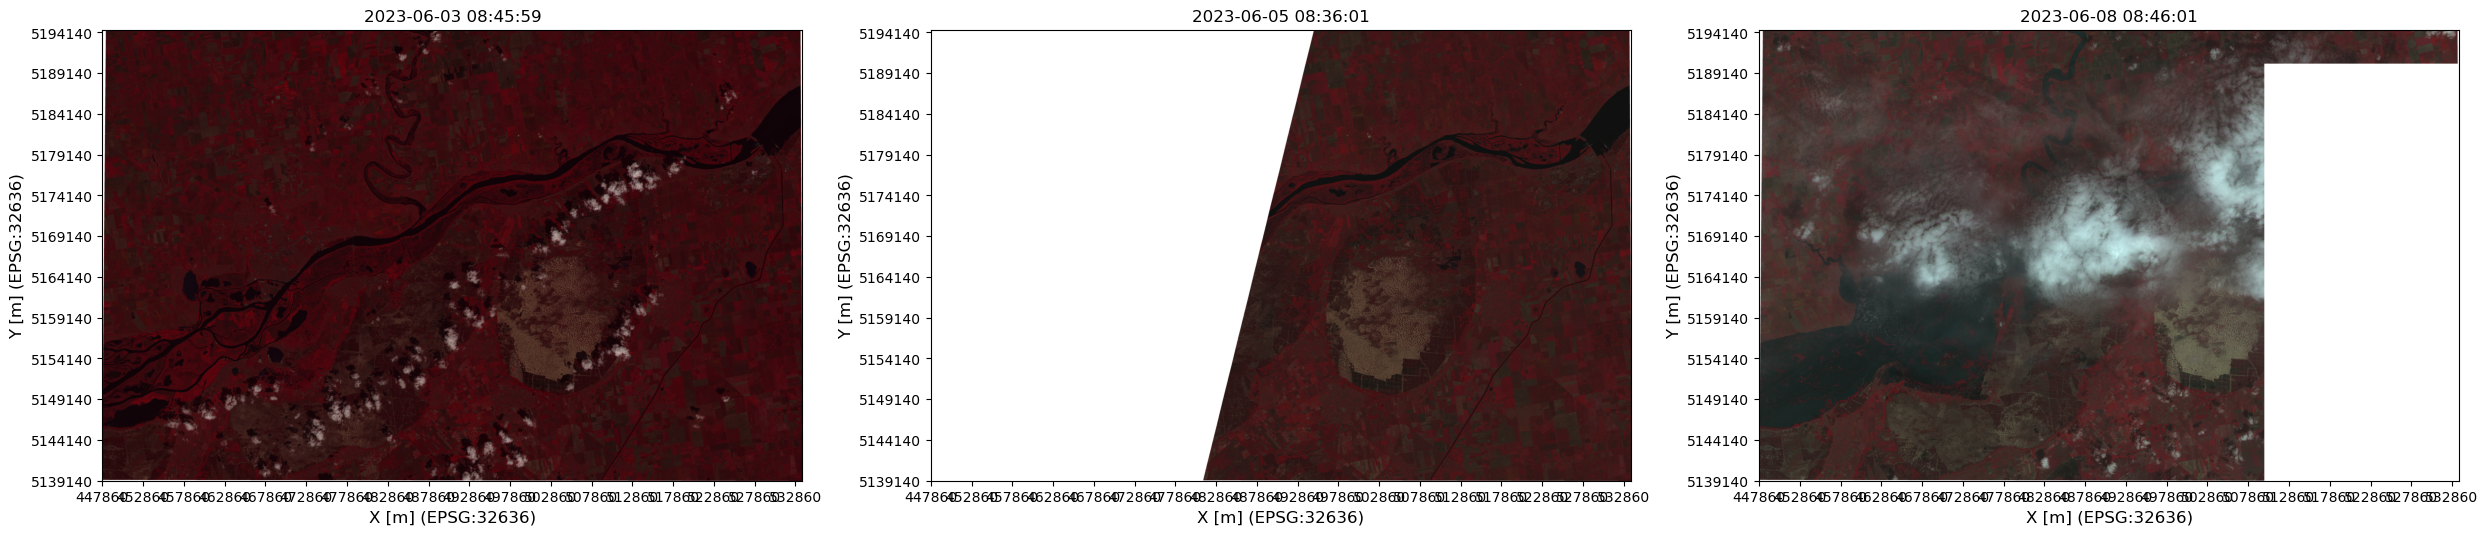

In [26]:
f = mapper_pop.plot(['nir_1', 'red', 'green'], figsize=(25, 25))

In [20]:
f.savefig('s2_rgb_01-09_Jun.png', bbox_inches='tight')

### Normalized Difference Water Index (NDWI)

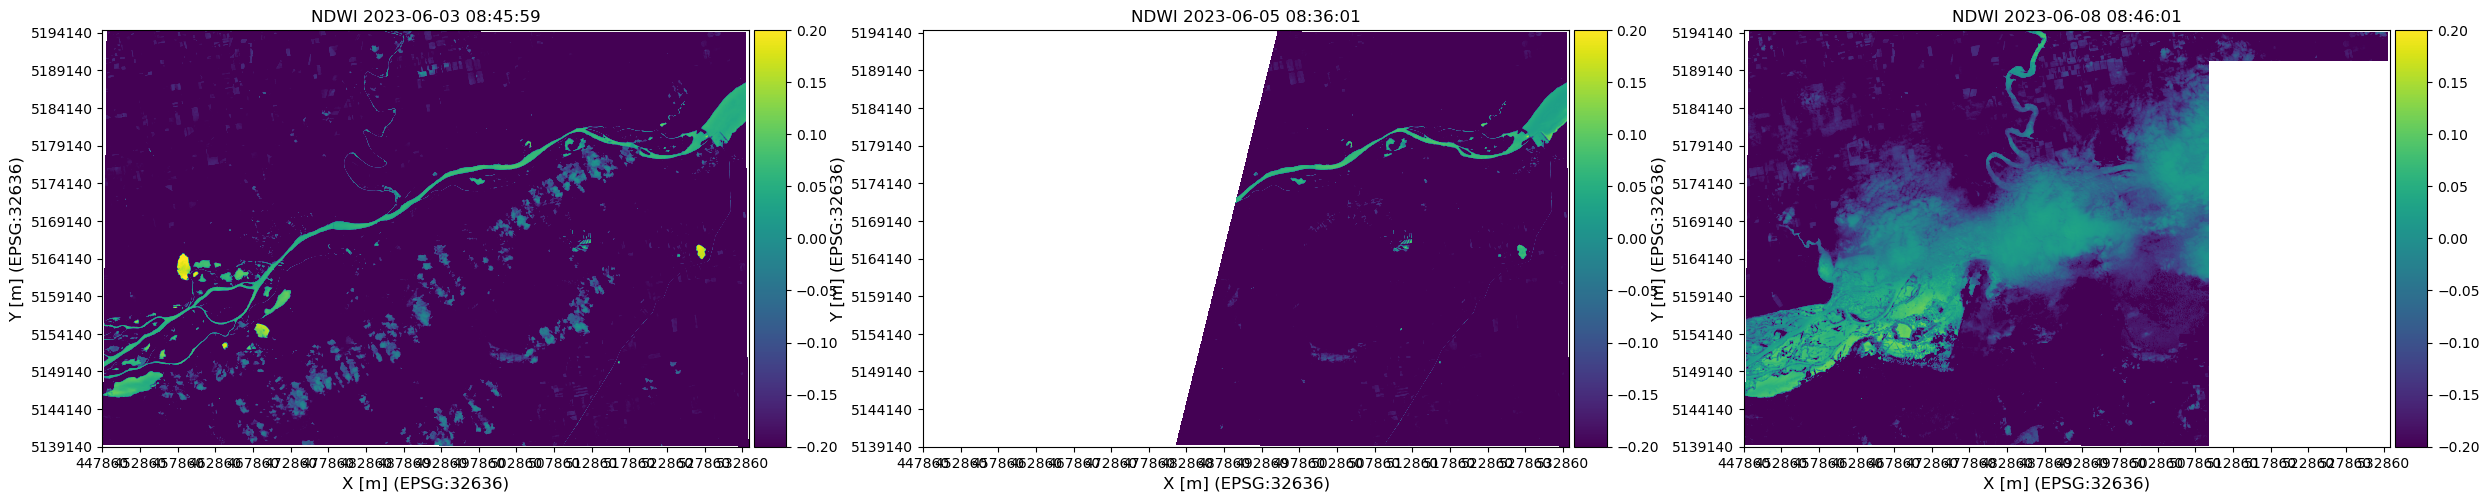

In [27]:
import matplotlib.pyplot as plt

f, ax  = plt.subplots(ncols=len(mapper_pop), figsize=(len(mapper_pop)*10, len(mapper_pop)*10))
idx = 0
for time_stamp, scene in mapper.data:
    scene['ndwi'].plot(vmin=-0.2, vmax=0.2, colormap='viridis', ax=ax[idx])
    ax[idx].set_title(f'NDWI {time_stamp}')
    idx += 1

In [23]:
f.savefig('ndwi.png', bbox_inches='tight')

#### Normalized Difference Vegetation Index (NDVI)

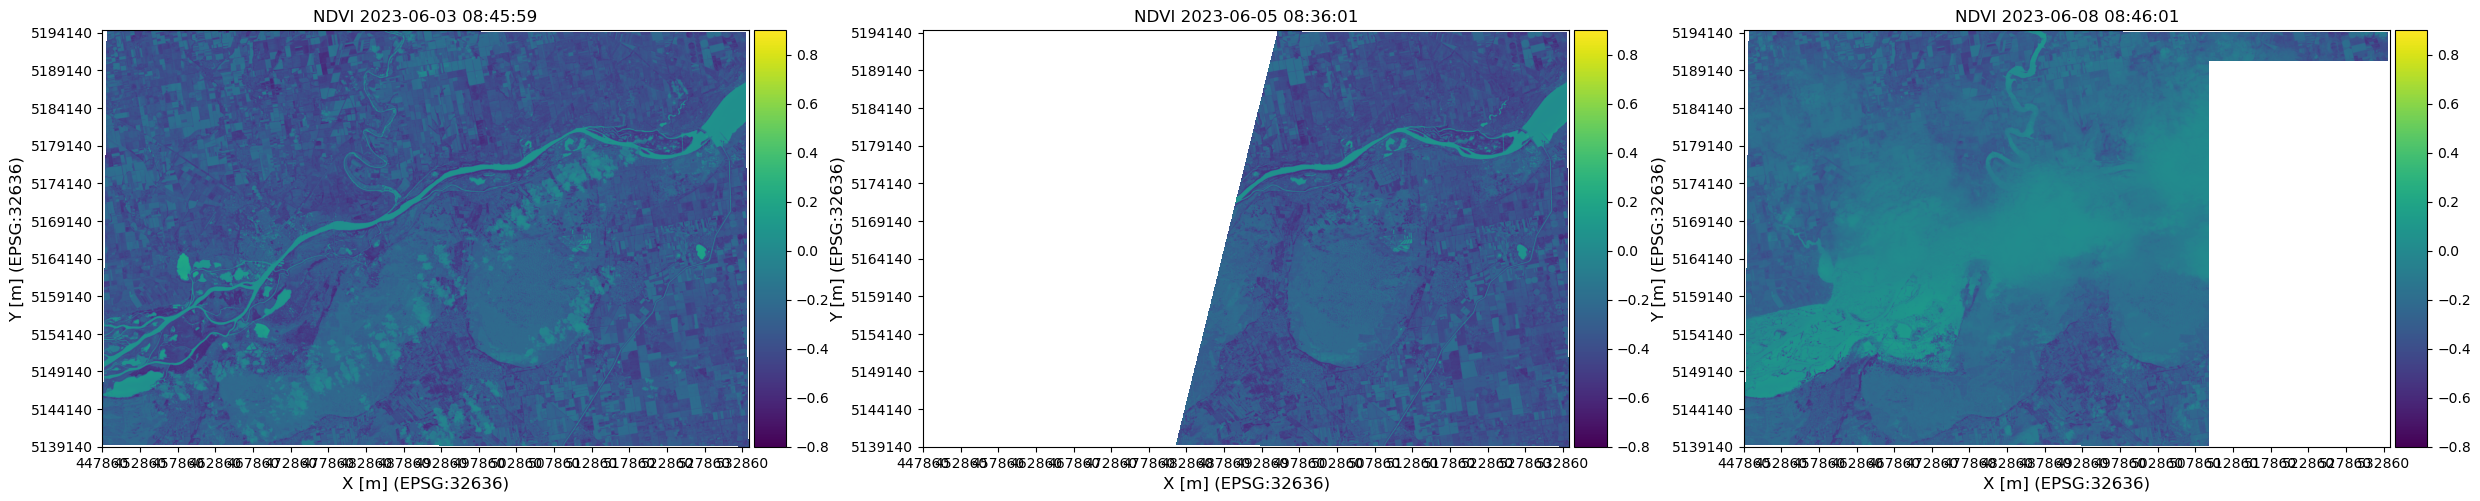

In [32]:
f, ax  = plt.subplots(ncols=len(mapper_pop), figsize=(len(mapper_pop)*10, len(mapper_pop)*10))
idx = 0
for time_stamp, scene in mapper.data:
    scene['ndwi'].plot(vmin=-0.8, vmax=0.9, colormap='viridis', ax=ax[idx])
    ax[idx].set_title(f'NDVI {time_stamp}')
    idx += 1

### Creating a Water Mask using the NDWI

Using a threshold of NDWI > 0.05 we extract a binary water mask from the Sentinel-2 images. These show a clear increase in the water area downstream the broken dam highlighting the massive spatial extent of the floodings.

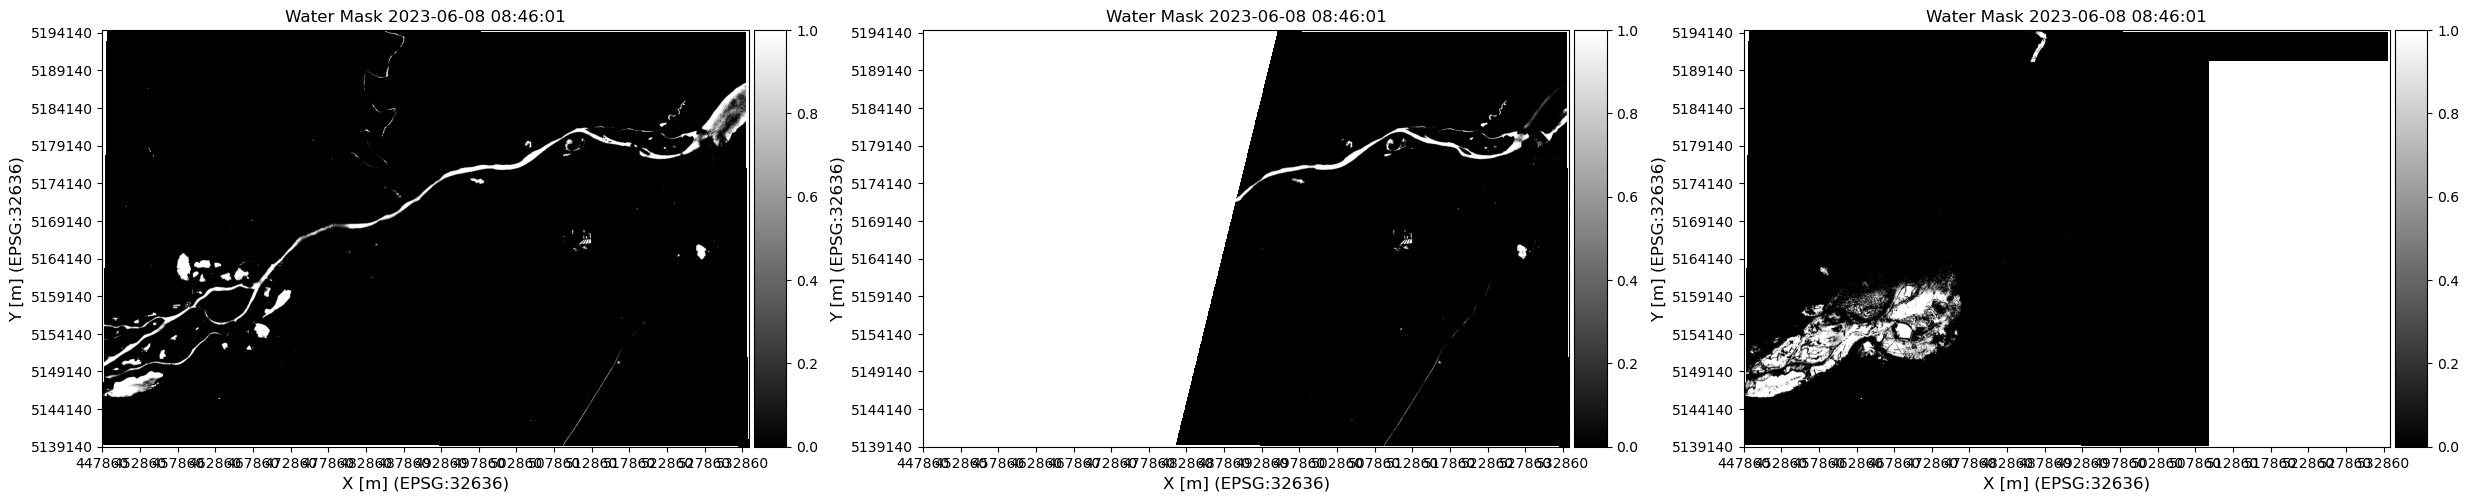

In [34]:
import matplotlib.pyplot as plt

f, ax  = plt.subplots(ncols=len(mapper_pop), figsize=(len(mapper_pop)*10, len(mapper_pop)*10))
idx = 0
for timestamp, scene in mapper.data:
    water_mask = scene['ndwi'] > 0.05
    water_mask.plot(ax=ax[idx], vmin=0, vmax=1)
    ax[idx].set_title(f'Water Mask {time_stamp}')
    idx += 1

In [35]:
f.savefig('water_mask_ndwi.png', bbox_inches='tight')